In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.formula.api as smf
from scipy.stats import mstats

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd")

In [2]:
df_train = pd.read_csv("train.csv")

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.000,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.000,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.000,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.000,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.000,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# Missing Value Count Function
def show_missing():
    missing = df_train.columns[df_train.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df_train[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*40)
print('Missing Data Percentage')
print(round(df_train[show_missing()].isnull().sum().sort_values(ascending = False)/len(df_train)*100,2))

Missing Data Count
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
--------------------------------------------------------------------------------
Missing Data Percentage
PoolQC         99.520
MiscFeature    96.300
Alley          93.770
Fence          80.750
FireplaceQu    47.260
LotFrontage    17.740
GarageYrBlt     5.550
GarageType      5.550
GarageFinish    5.550
GarageQual      5.550
GarageCond      5.550
BsmtFinType2    2.600
BsmtExposure    2.600
BsmtFinType1    2.530
BsmtCond        2.530
BsmtQual        2.530
MasVnrArea      0.550
MasVnrType      0.550
Electrical      0.070
dtype: float64


In [7]:
# Dropping columns missing 40%+ data
df_train = df_train.drop(labels=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)

In [8]:
# Dropping categorical features before deciding features for regression
categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
df_train = df_train.drop(df_train[categorical_feats], axis=1)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
F

In [10]:
# Fill missing values with 0 since attributes likely don't exist for row
df_train = df_train.fillna(0)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1460 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
F

In [12]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,57.623,10516.828,6.099,5.575,1971.268,1984.866,103.117,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,34.664,9981.265,1.383,1.113,30.203,20.645,180.731,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,0.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,42.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,63.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,79.000,11601.500,7.000,6.000,2000.000,2004.000,164.250,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


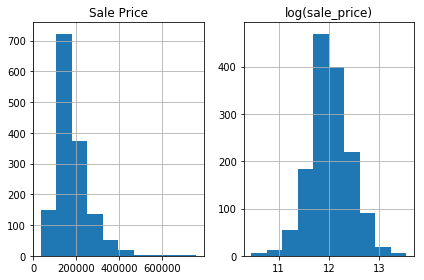

In [13]:
#Log the population variable 
plt.figure(figsize=(12, 10))
population = pd.DataFrame({"Sale Price":df_train["SalePrice"], "log(sale_price)":np.log(df_train["SalePrice"])})
population.hist(bins = 10)
plt.tight_layout()
plt.show()

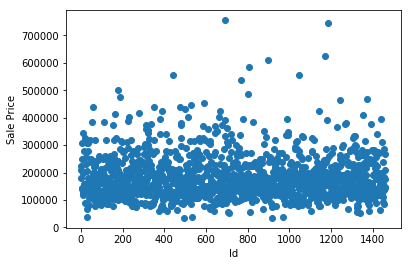

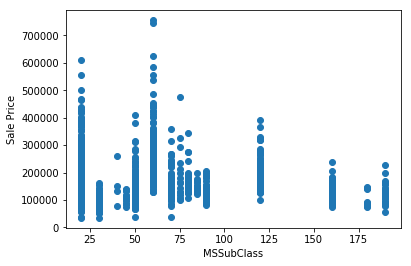

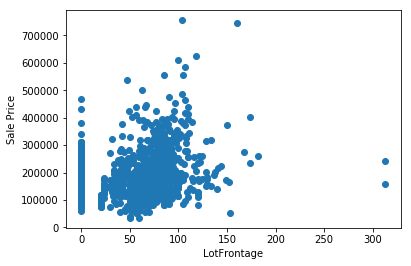

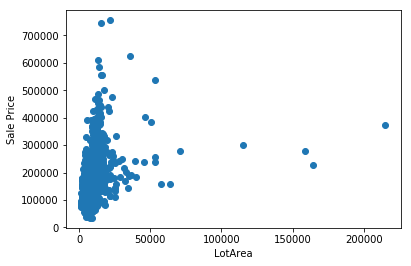

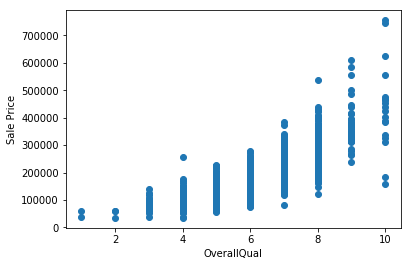

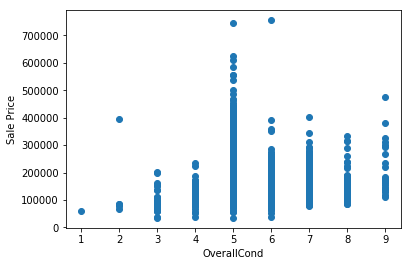

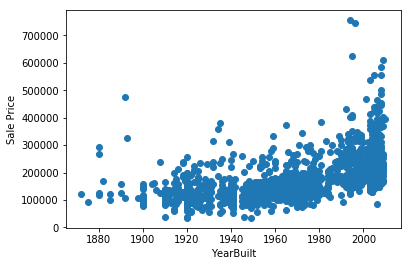

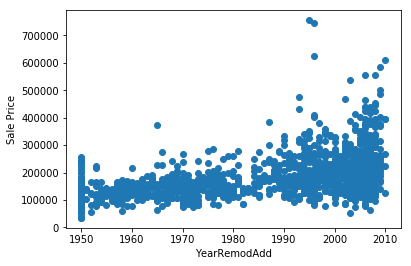

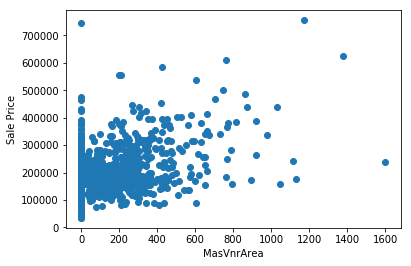

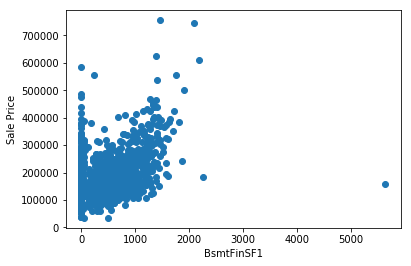

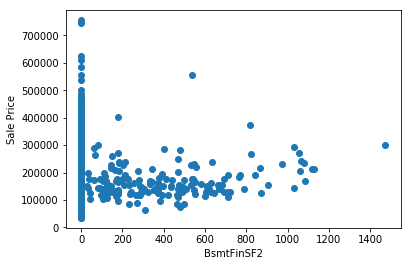

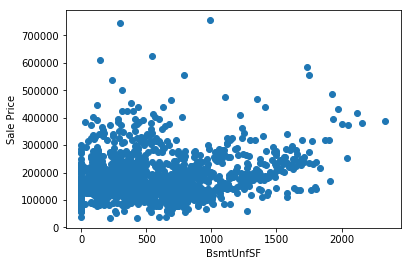

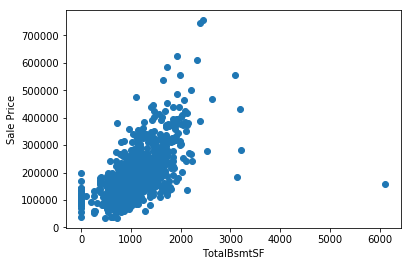

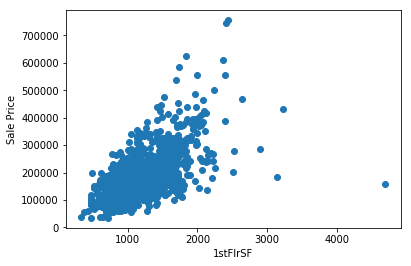

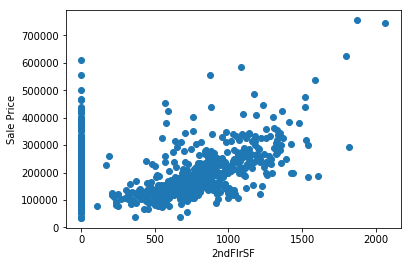

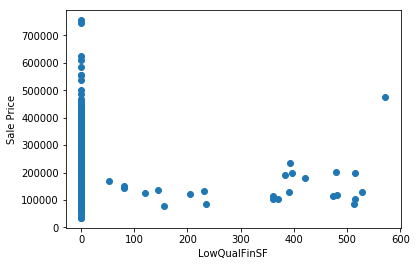

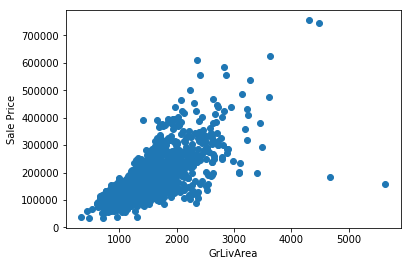

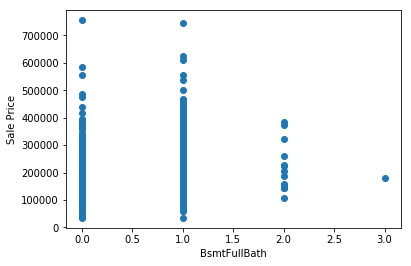

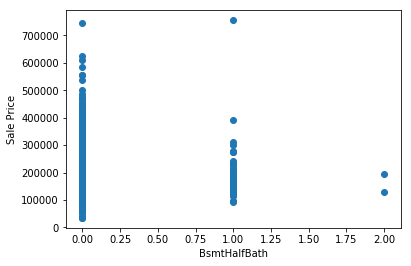

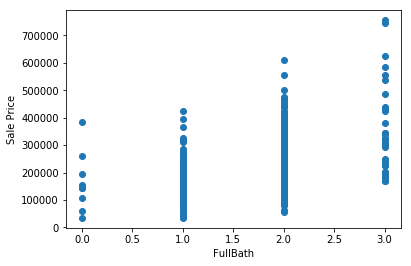

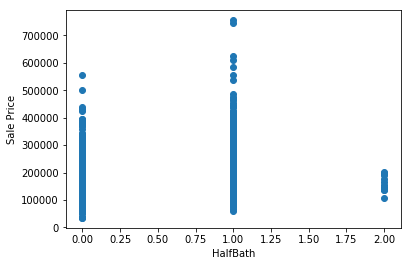

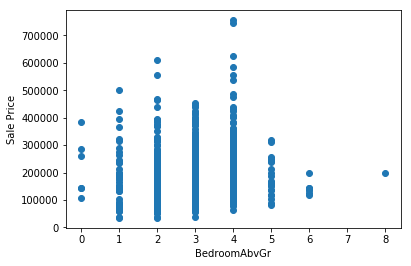

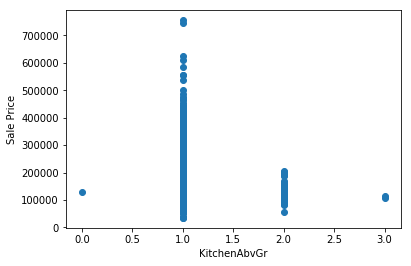

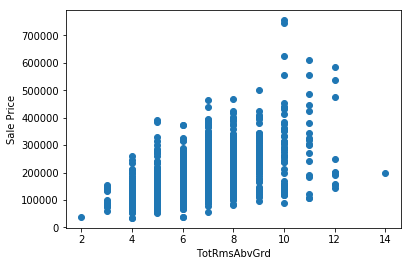

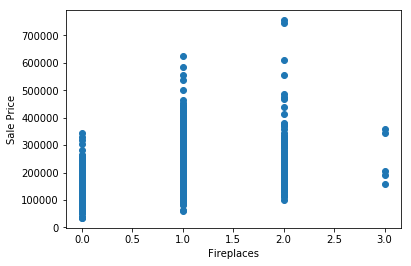

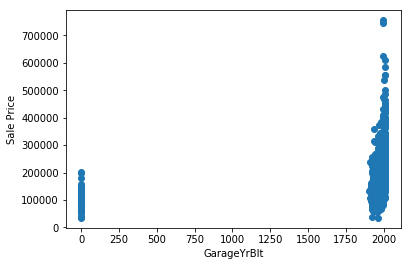

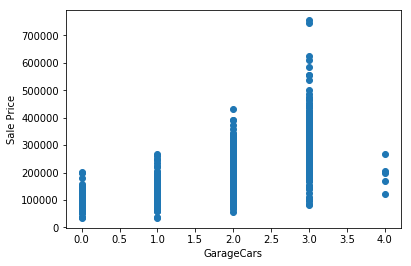

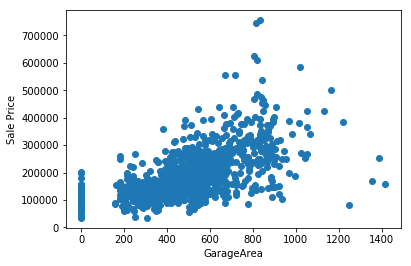

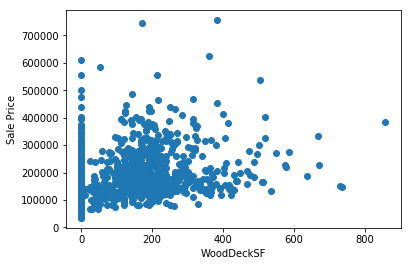

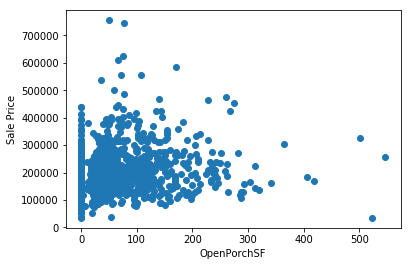

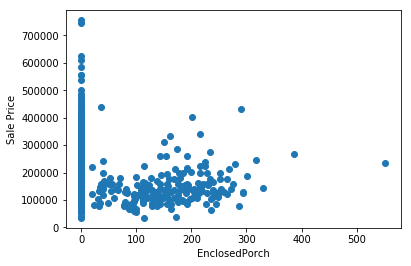

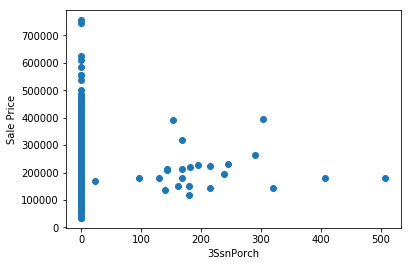

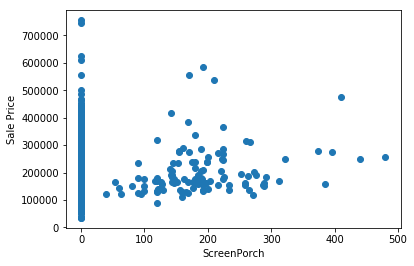

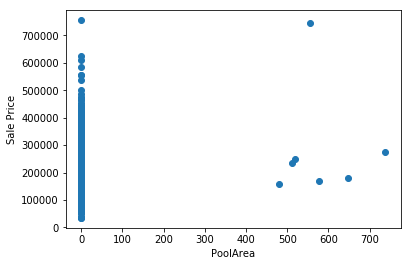

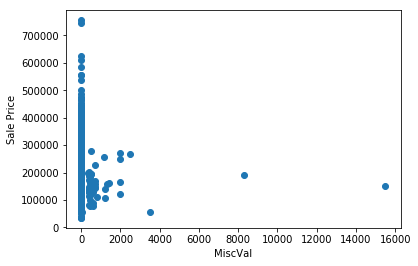

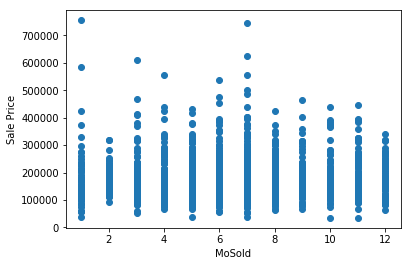

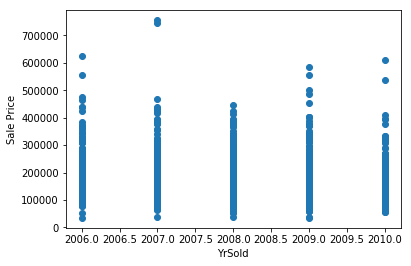

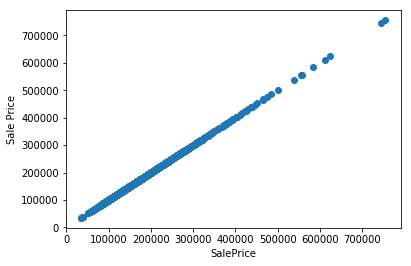

In [14]:
for col in df_train.columns:
    plt.scatter(df_train[col], df_train['SalePrice'])
    plt.xlabel(col)
    plt.ylabel('Sale Price')
    plt.show()

In [15]:
# Drop non-linear features
df_train = df_train.drop(labels=['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], axis=1)

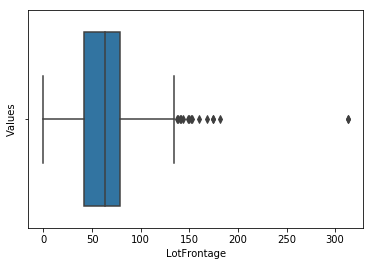

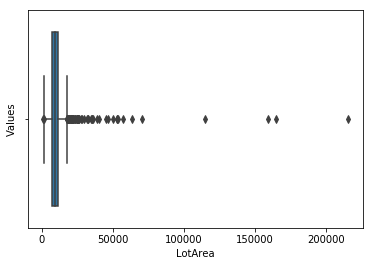

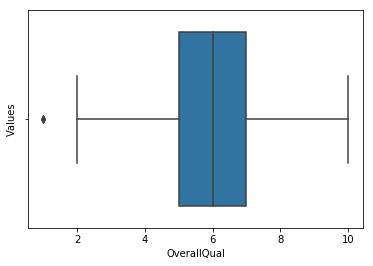

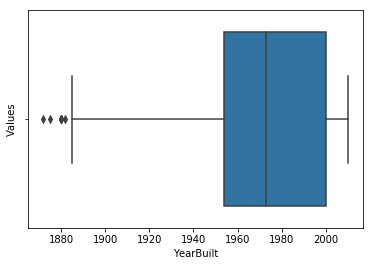

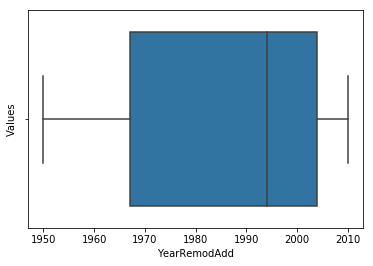

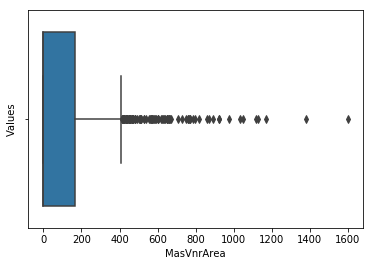

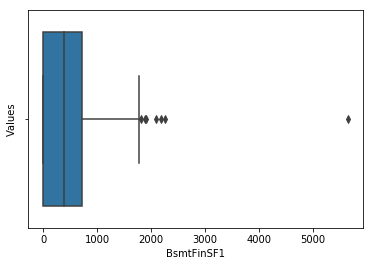

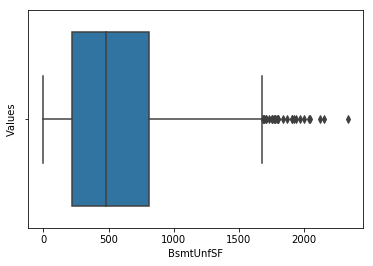

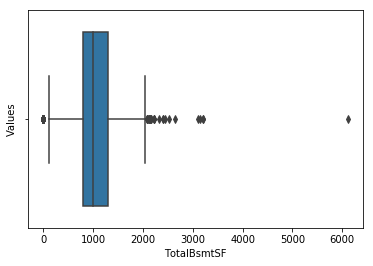

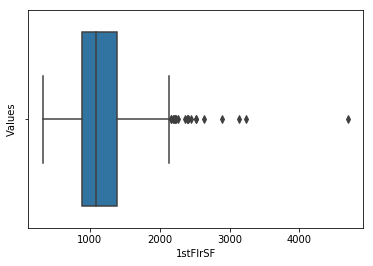

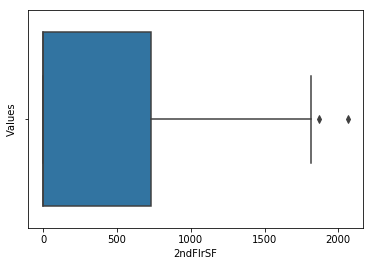

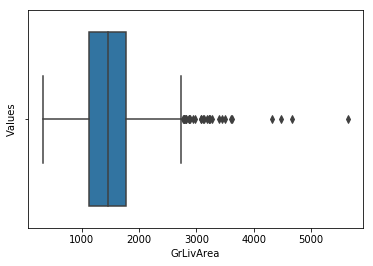

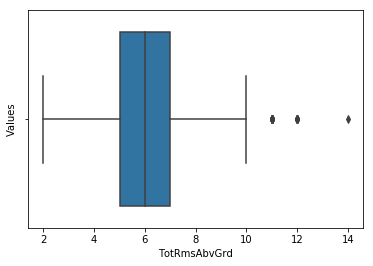

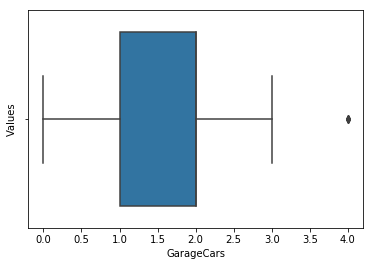

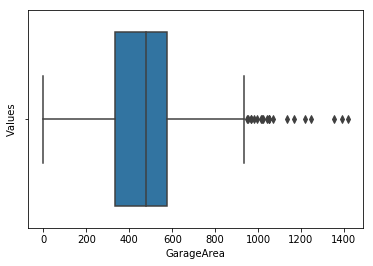

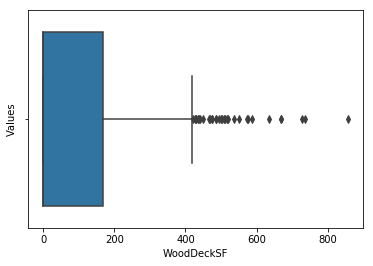

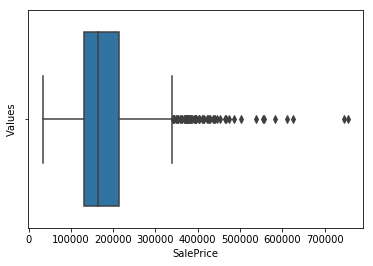

In [16]:
for col in df_train.columns:
    sns.boxplot(df_train[col])
    plt.xlabel(col)
    plt.ylabel('Values')
    plt.show()

In [17]:
from scipy import stats
# Remove outliers from the scaled dataset

df_train[(np.abs(stats.zscore(df_train)) < 3).all(axis=1)]

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageCars,GarageArea,WoodDeckSF,SalePrice
0,65.000,8450,7,2003,2003,196.000,706,150,856,856,854,1710,8,2,548,0,208500
1,80.000,9600,6,1976,1976,0.000,978,284,1262,1262,0,1262,6,2,460,298,181500
2,68.000,11250,7,2001,2002,162.000,486,434,920,920,866,1786,6,2,608,0,223500
3,60.000,9550,7,1915,1970,0.000,216,540,756,961,756,1717,7,3,642,0,140000
4,84.000,14260,8,2000,2000,350.000,655,490,1145,1145,1053,2198,9,3,836,192,250000
5,85.000,14115,5,1993,1995,0.000,732,64,796,796,566,1362,5,2,480,40,143000
6,75.000,10084,8,2004,2005,186.000,1369,317,1686,1694,0,1694,7,2,636,255,307000
7,0.000,10382,7,1973,1973,240.000,859,216,1107,1107,983,2090,7,2,484,235,200000
8,51.000,6120,7,1931,1950,0.000,0,952,952,1022,752,1774,8,2,468,90,129900
9,50.000,7420,5,1939,1950,0.000,851,140,991,1077,0,1077,5,1,205,0,118000


In [18]:
df_train.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageCars,GarageArea,WoodDeckSF,SalePrice
0,65.000,8450,7,2003,2003,196.000,706,150,856,856,854,1710,8,2,548,0,208500
1,80.000,9600,6,1976,1976,0.000,978,284,1262,1262,0,1262,6,2,460,298,181500
2,68.000,11250,7,2001,2002,162.000,486,434,920,920,866,1786,6,2,608,0,223500
3,60.000,9550,7,1915,1970,0.000,216,540,756,961,756,1717,7,3,642,0,140000
4,84.000,14260,8,2000,2000,350.000,655,490,1145,1145,1053,2198,9,3,836,192,250000


In [28]:
names = df_train.columns

df_scaled = pd.DataFrame(preprocessing.scale(df_train), columns=names)

In [29]:
# Instantiate and fit model
regr = linear_model.LinearRegression()
Y = df_scaled['SalePrice']
X = df_scaled.drop('SalePrice', axis=1)
regr.fit(X,Y)

# Save results
regr_params = np.append(regr.coef_, regr.intercept_)

# Inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.01237207  0.06588146  0.35329371  0.06019076  0.08690961  0.06846985
  0.05848704 -0.04594291  0.09339208  0.14263636  0.11143934  0.12496361
  0.02776959  0.10317564  0.01479057  0.04660605]

Intercept: 
 -3.8918782896941053e-16

R-squared:
0.7931720063556089


In [30]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regr, X, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.78 (+/- 0.22)


In [31]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X, Y)

print(knn.score(X, Y))

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X, Y)

print(knn_w.score(X, Y))

0.8317377310030596
0.9999906387508668


In [32]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=10)
print('Weighted Accuracy: %0.2f (+/- %0.2f)' % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.80 (+/- 0.12)
Weighted Accuracy: 0.81 (+/- 0.12)


For each model we see decent accuracy as well as little evidence of overfitting except on our weighted KNN model based on pure model score. While our KNN models have higher accuracy they also have less variance in the error, whereas the OLS model has lower accuracy but contains more variance. 

For this particular data, I would focus on tuning my KNN models either thru better feature selection or feature engineering which would most likely boost our model's performance. 

The only reason I might swap models is if my outcome variable had less variance to try and capture through my models. 

As for why this data performs better thru KNN versus OLS, I believe it's because the scales of the features as well as multicollinearity is easier to deal with using KNN compared to OLS which demands more from our data. 